In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) == 3
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
import json
from dotmap import DotMap

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]


In [2]:
import models
import training
import datasets
import vizualization
import schedules

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [3]:
config = DotMap({
    'ds': 'mnist',
    'distributed': True,
    'minibatch_size': 8,
    'n_steps': 120001,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'noise_fraction': 0.1,
    'display_images': True,
    'display_image_interval': 5000,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': True,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 1000,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

Example integers sampled from gamma distribution.
tf.Tensor(
[182   8  24 150 199 147 194 286  34   6  85 399  11 302 144 211 280  59
  15  26  76  46  21  15 125  85 230 239 701 244 118  68 114 234  63 247
 149  96 181 109 269  70 286 100 114 173  71 110  28 324 457 319 176 137
 176 168  24  34 129 204  77  79  12 111 172 365 115 190 122 188 137 237
  36 187  79  29 428 184 388 231  70   6 136 123 441  71  50 322   4  25
  97  86  30  18  61 330 193 152 234  15], shape=(100,), dtype=int32)


centroids.shape (4, 1)


Not using gradient accumulation


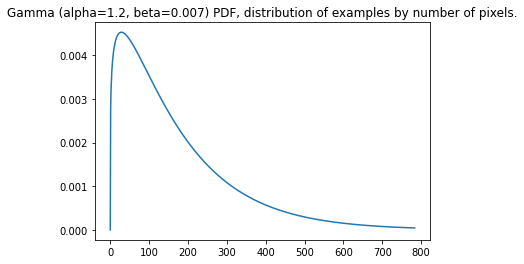

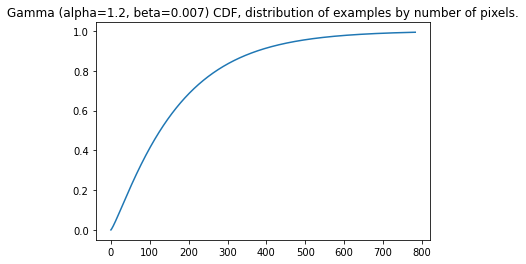

In [42]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'buffer_size': 60000,
        'name': 'mnist',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'celeb': {
        'name': 'celeb_a',
        'buffer_size': 10000,
        'n_colors': 16,
        'n_color_dims': 3,
        'image_size': (218, 178),
        'rescale': (32, 39),
    }
})

config.dataset = ds_configs[config.ds]
config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
datasets.plot_distribution(config, gamma_dist, gamma_name)

dataset, metadata = tfds.load(config.dataset.name, with_info=True, as_supervised=True)

ds_train_original = dataset['train']
ds_test_original = dataset['test']

centroids = datasets.find_centroids(config, ds_train_original)

ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


(24, 784, 3)
(24, 784)


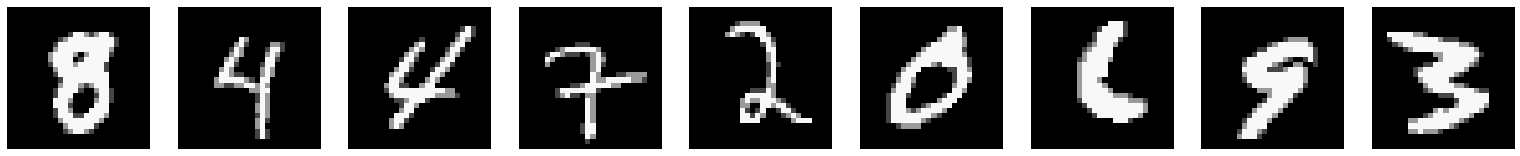

In [43]:
display_colors, display_idxs, *_ = next(iter(ds_train))
if config.grad_accum_steps:
    display_colors,display_idxs = display_colors[0],display_idxs[0]
viz.showSeq(display_colors, display_idxs, config.dataset.image_size, max_images=9)

In [53]:


# model config
config.model = DotMap({
    'n_colors': config.dataset.n_colors,
    'n_color_dims': config.dataset.n_color_dims,
    'image_size': config.dataset.image_size,
    'seq_len': config.dataset.image_size[0] * config.dataset.image_size[1],
    'n_enc_a_layers': 6,
    'n_enc_b_layers': 3,
    'ffl_dim': 1024,
    'embd_dim': 512,
    'n_dec_layers': 2,
    'dec_dim': 512,
    'n_heads': 8,
    'dropout_rate': 0.1,
    'use_idxs_input': True,
    'architecture': 'anp',
    'position_embedding': 'pos_enc',
    'activation': 'swish',
})
keras.mixed_precision.set_global_policy('mixed_float16')

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config)))

ds_train_dist = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'full_combination'

model_name = models.model_name(config)
print(model_name)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


cuda5-28x28-noise0.1-bs3x1x8


In [54]:
evaler = training.Evaluator(config, model, optimizer, viz, ds, ds_train_dist, ds_test)

training_loop = training.TrainingLoop(config, evaler, model_name)

learning_rate,▁▂▃▅▆▇███████
log_loss_mean,█▃▂▂▂▁▁▂▁▂▁▁▁
loss,█▅▃▂▆▁▂▇▃▂▂▁▃
loss_mean,█▃▂▂▂▁▁▂▁▂▁▁▁
learning_rate,0.0004
log_loss_mean,0.61311
loss,1.90505
loss_mean,1.84615


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 153 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Step 0, Loss (last minibatch): 0.7455815076828003, Loss (80 step avg.): 0.7455815076828003


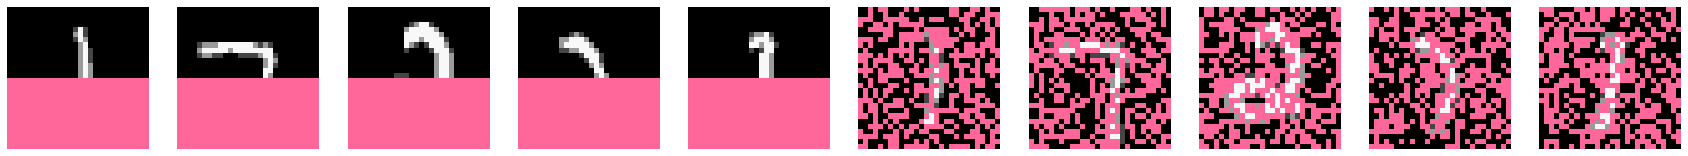

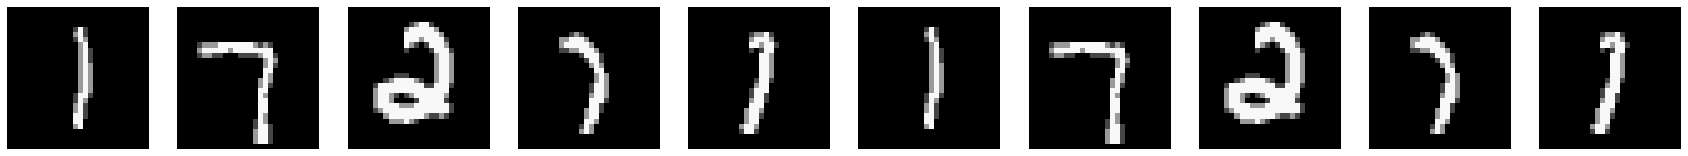

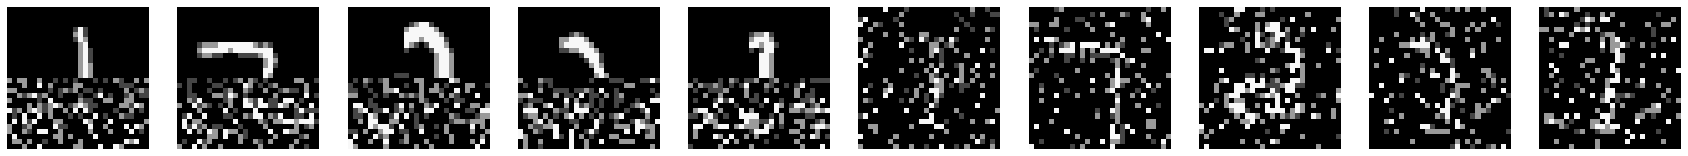

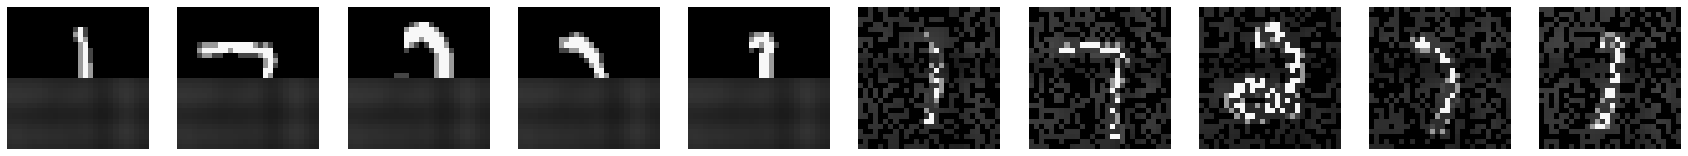

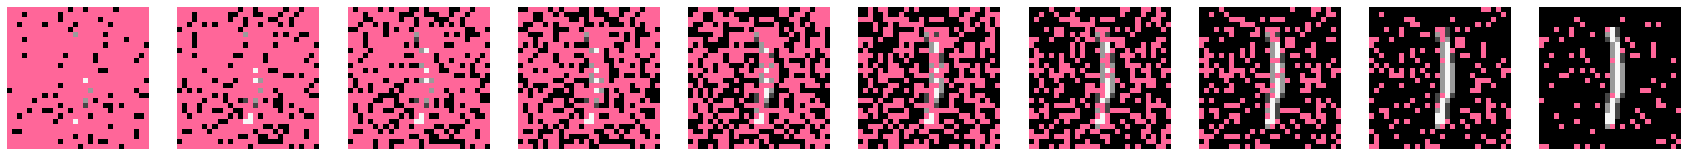

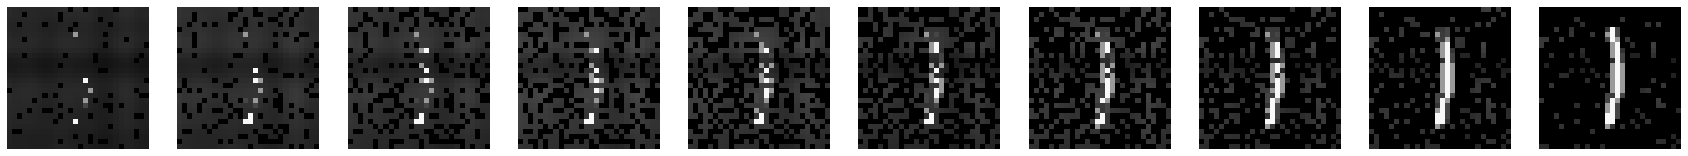

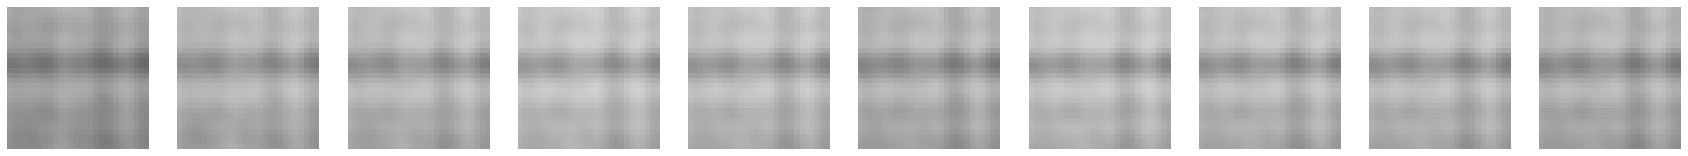

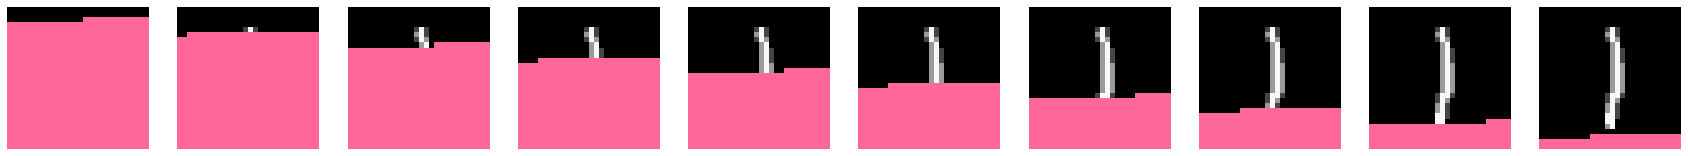

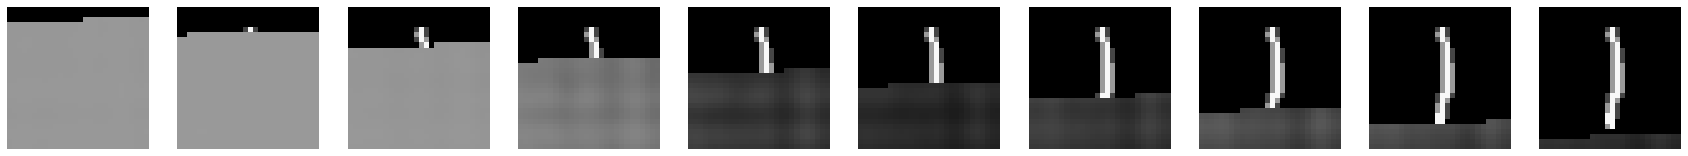

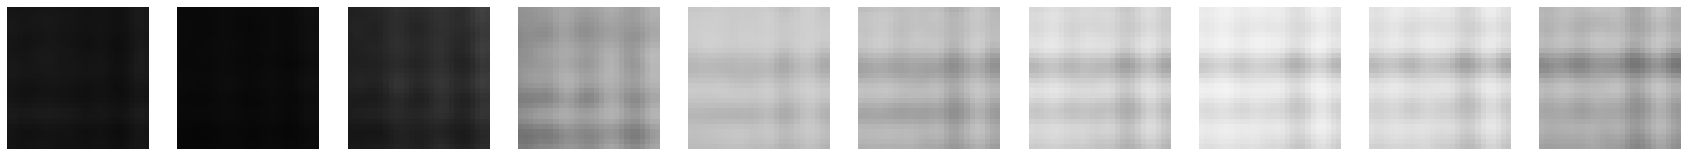

Step 162, Loss (last minibatch): 0.45457911491394043, Loss (80 step avg.): 0.47991090792196767


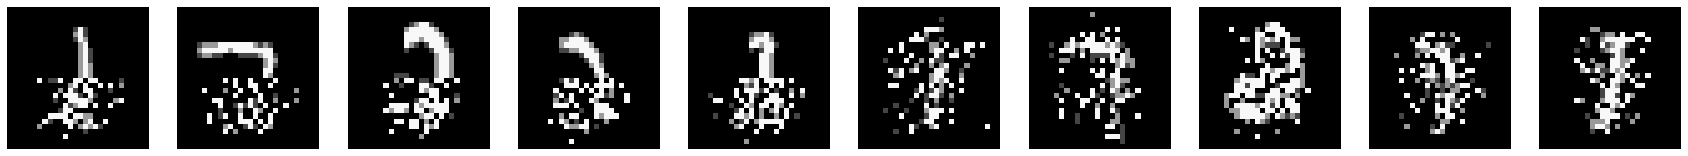

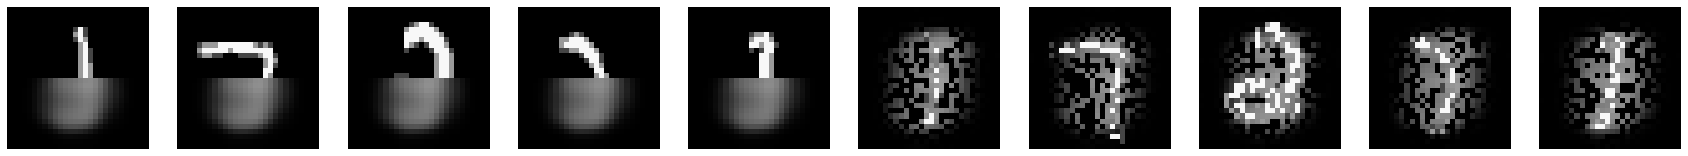

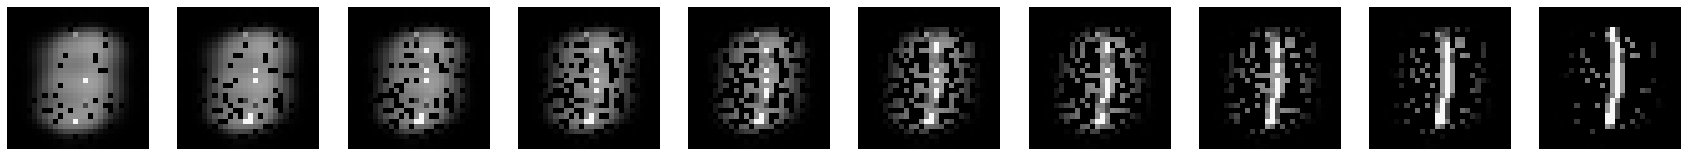

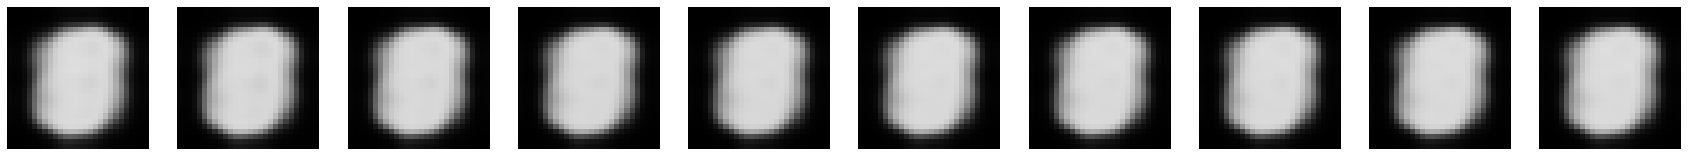

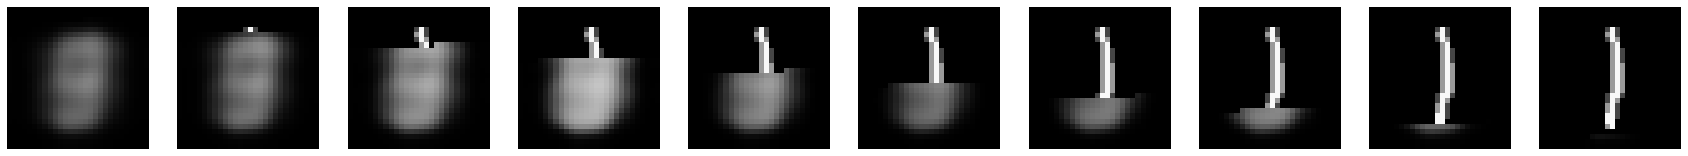

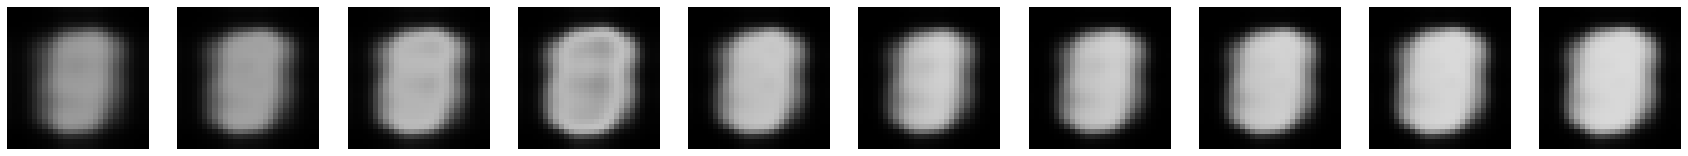

Step 856, Loss (last minibatch): 0.41079840064048767, Loss (80 step avg.): 0.4318519628342287


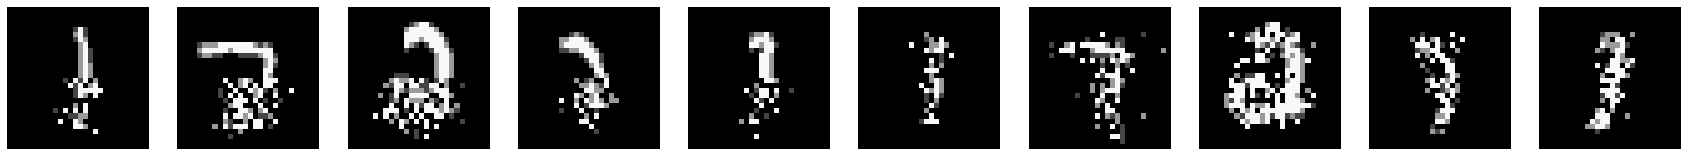

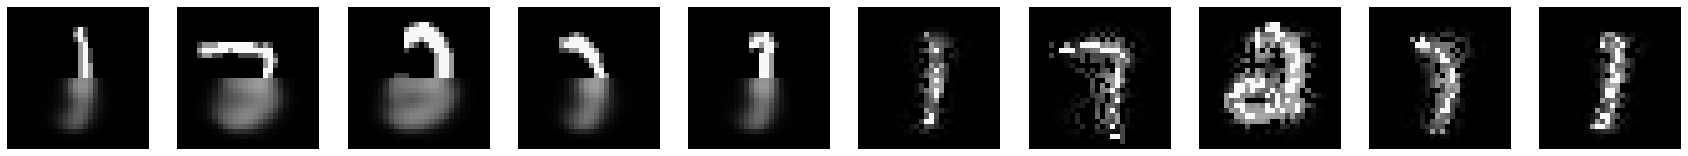

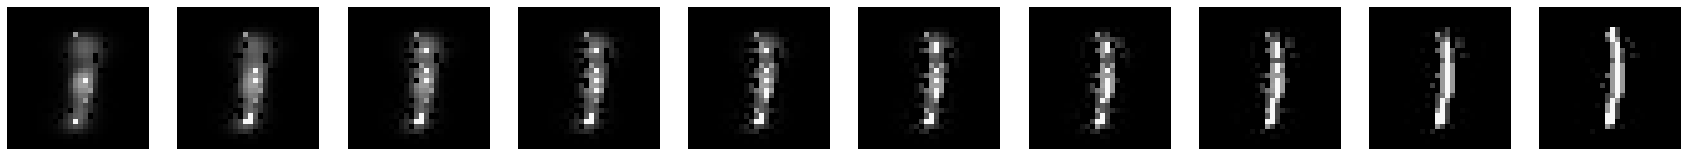

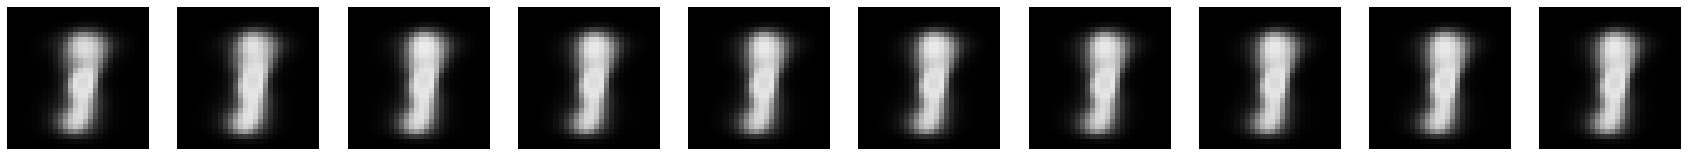

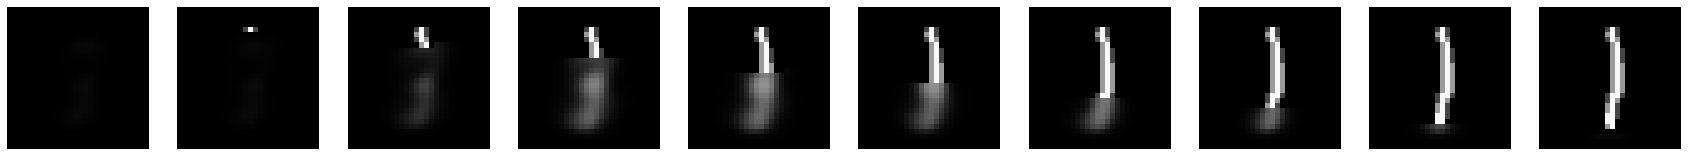

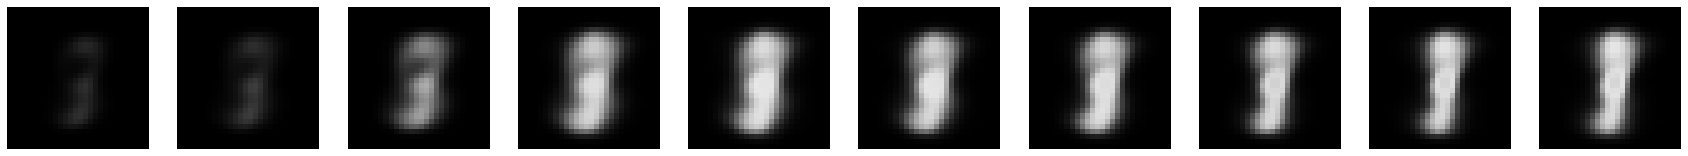

Step 931, Loss (last minibatch): 0.33877110481262207, Loss (80 step avg.): 0.3881548860190827


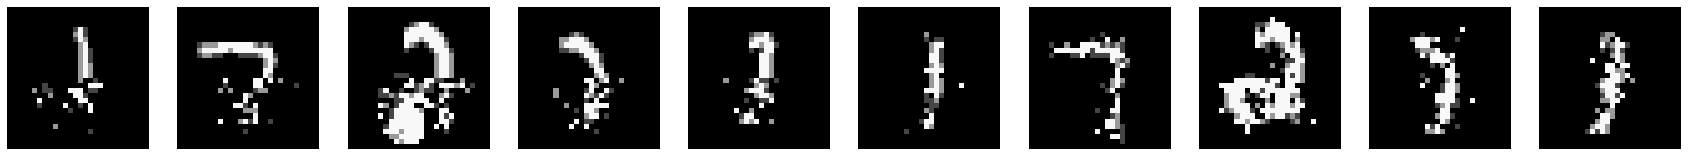

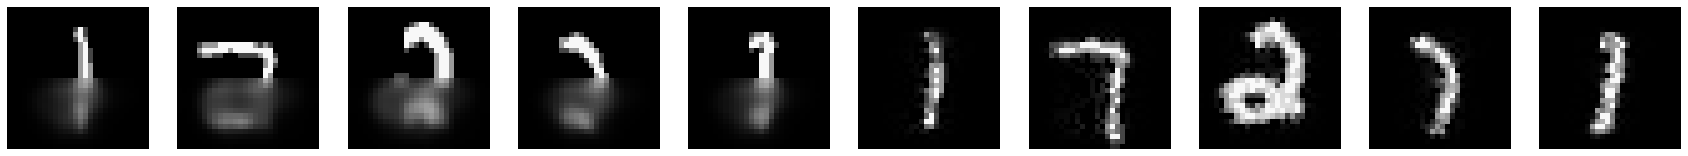

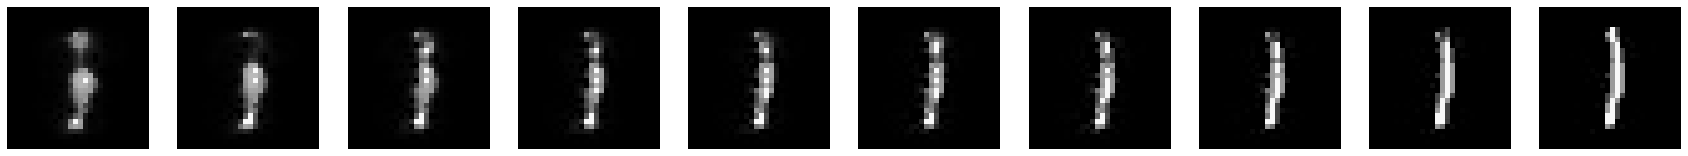

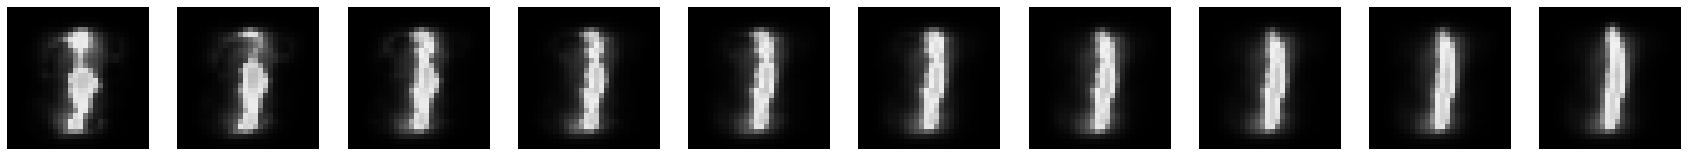

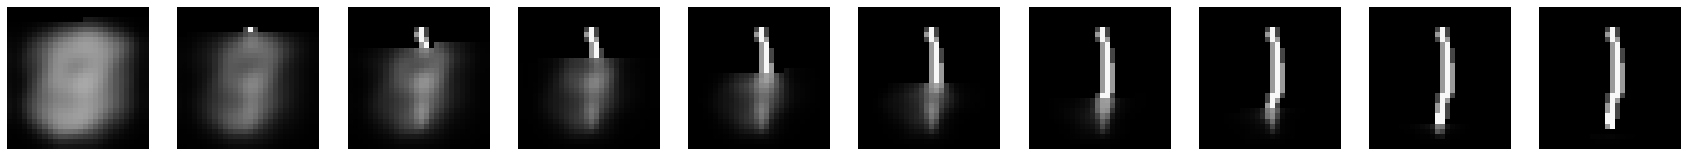

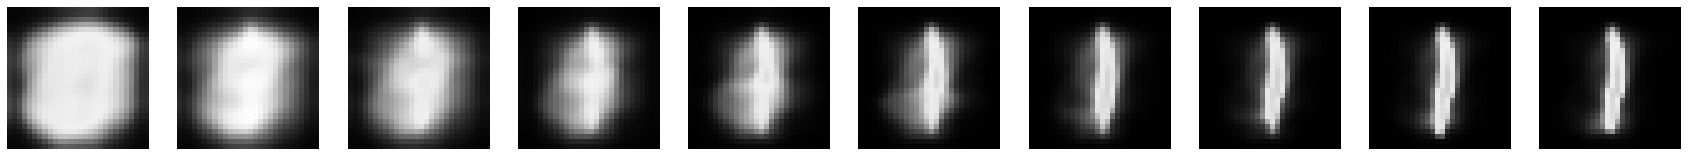

Step 964, Loss (last minibatch): 0.32095927000045776, Loss (80 step avg.): 0.3484080025443324


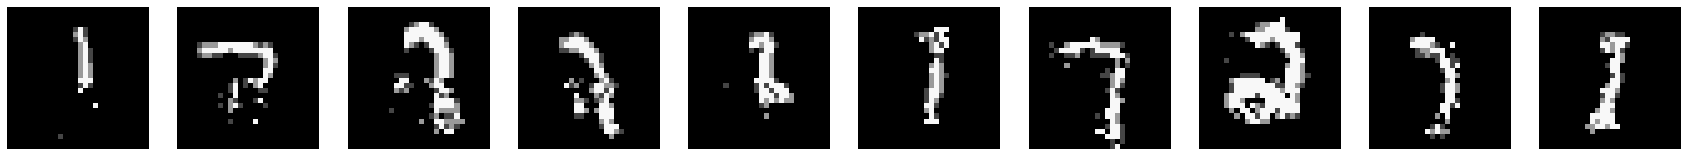

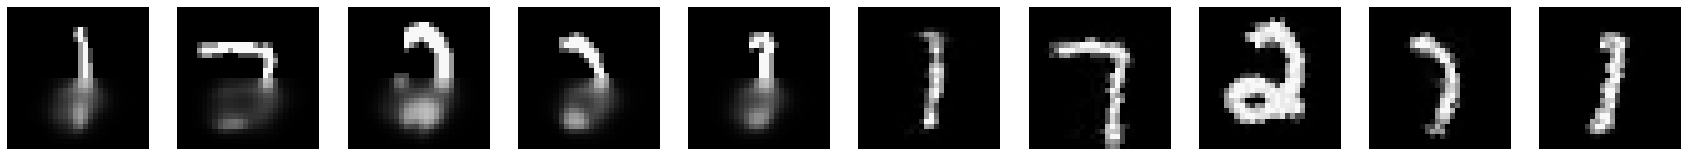

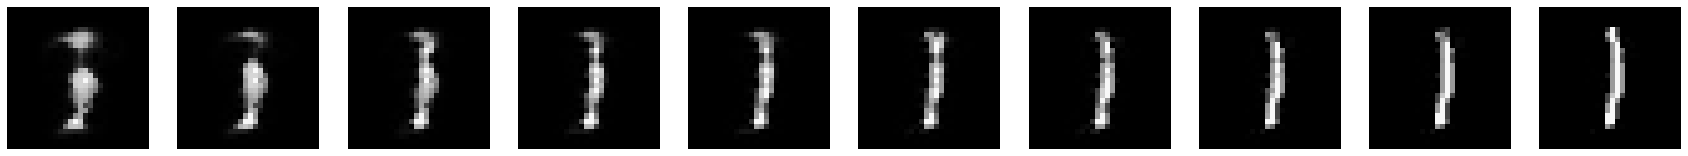

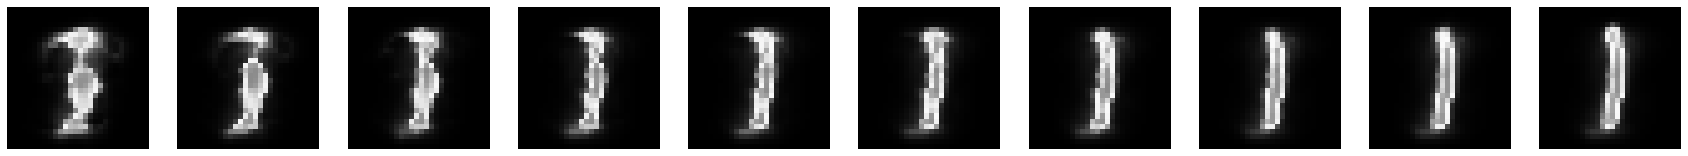

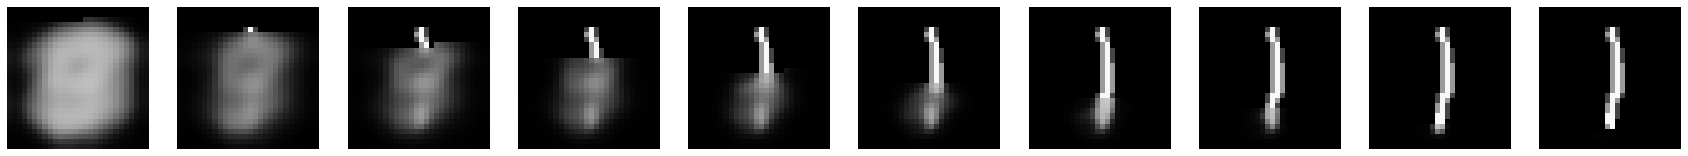

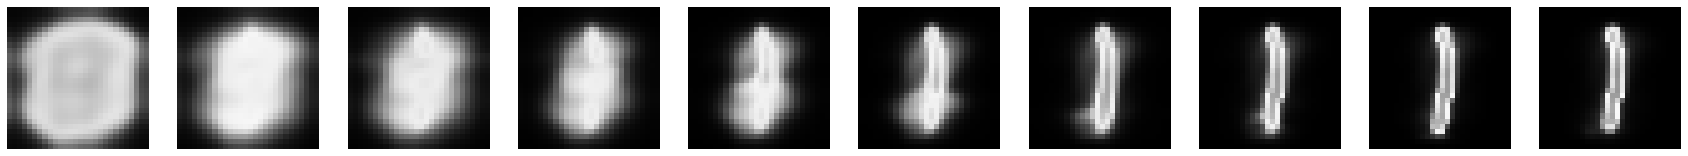

Step 1109, Loss (last minibatch): 0.23861698806285858, Loss (80 step avg.): 0.3129815220096965


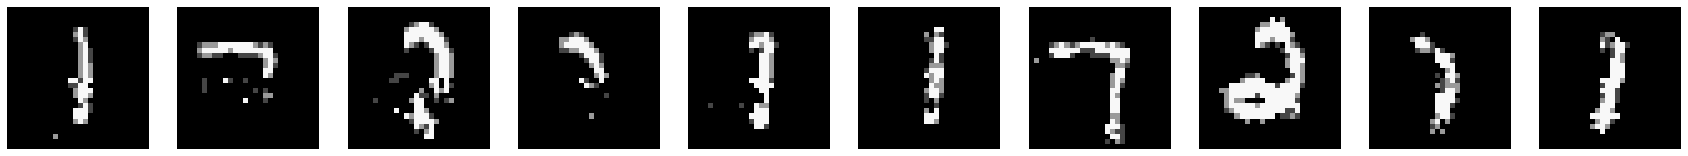

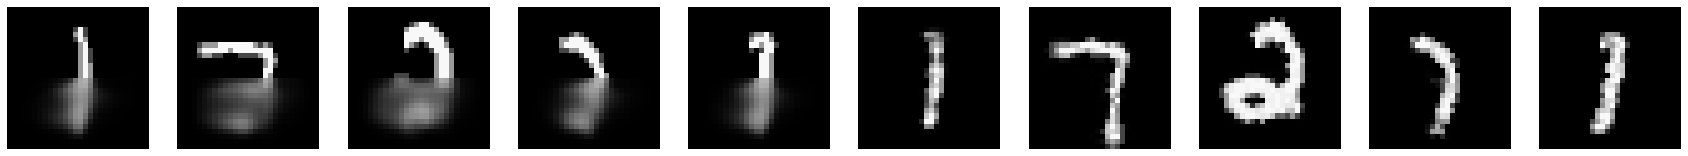

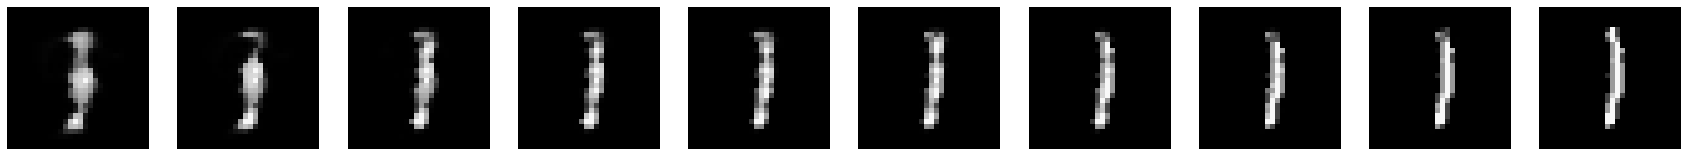

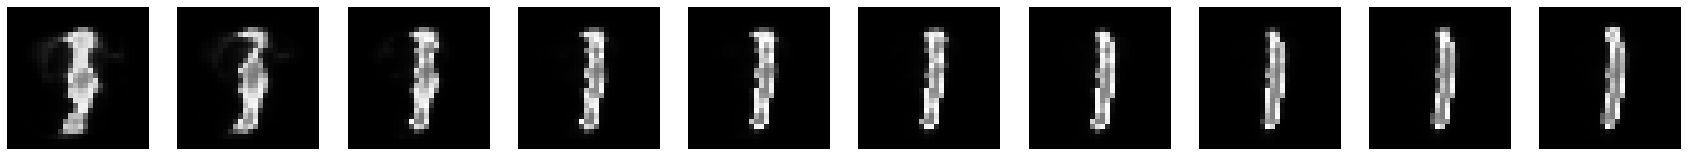

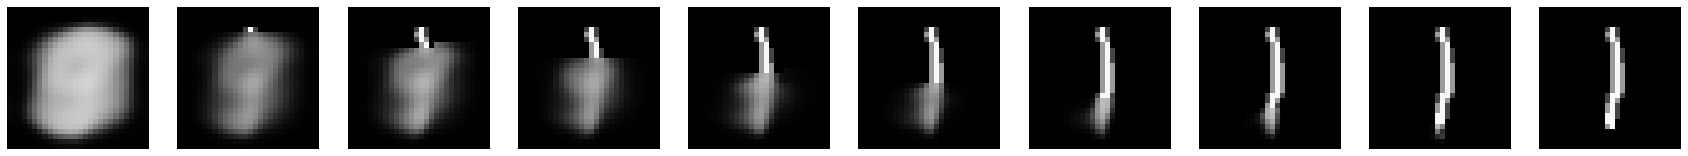

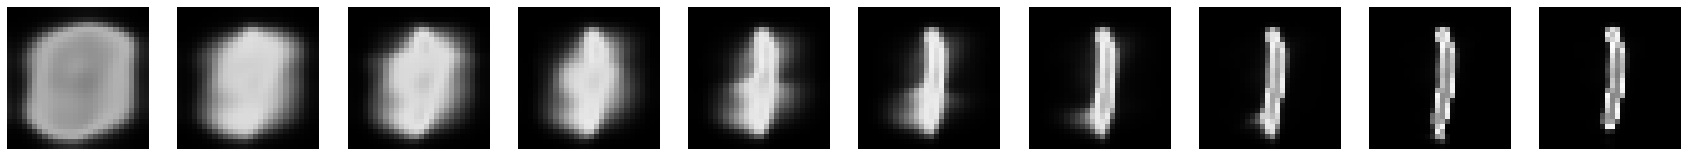

Step 1524, Loss (last minibatch): 0.22266165912151337, Loss (80 step avg.): 0.2815522759416957


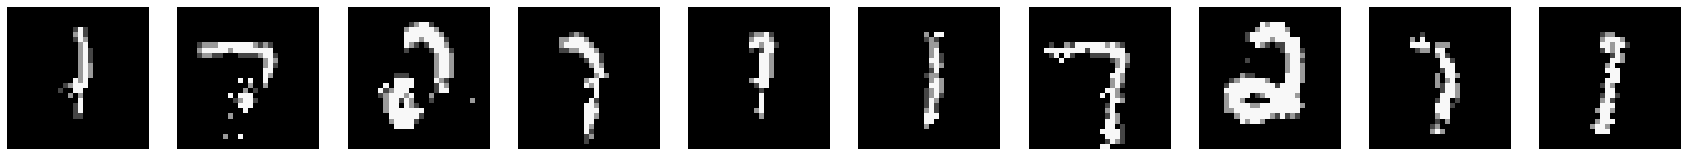

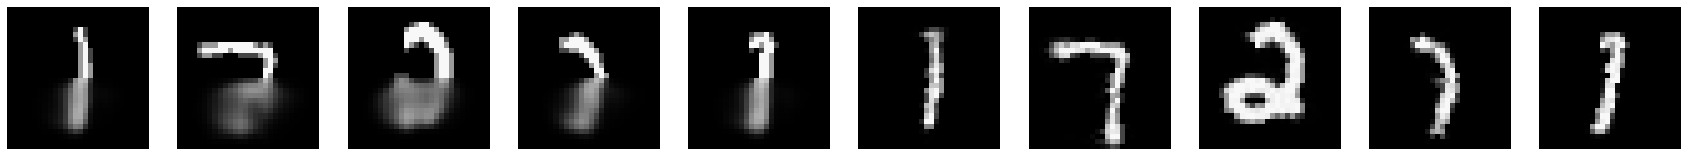

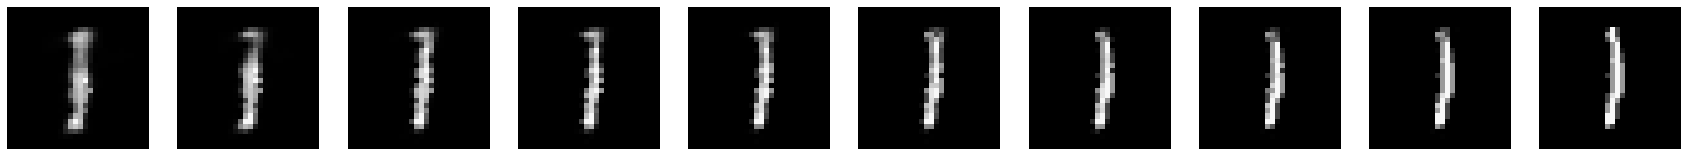

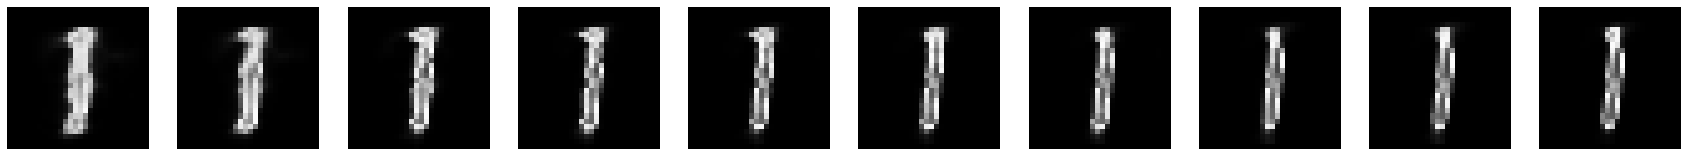

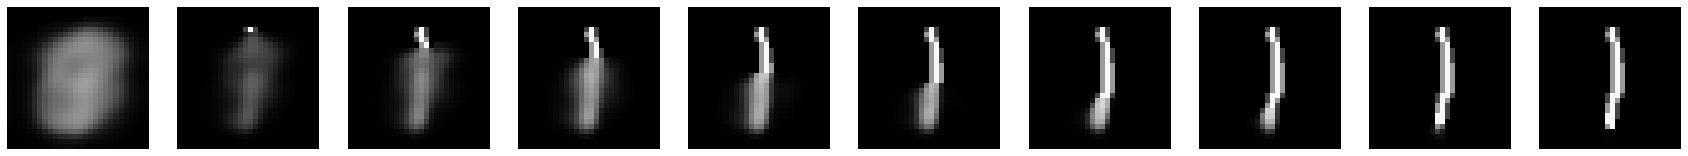

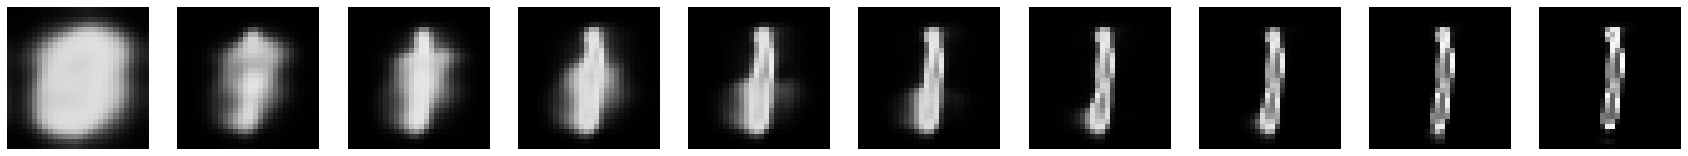

Step 2976, Loss (last minibatch): 0.24760708212852478, Loss (80 step avg.): 0.25280086365011


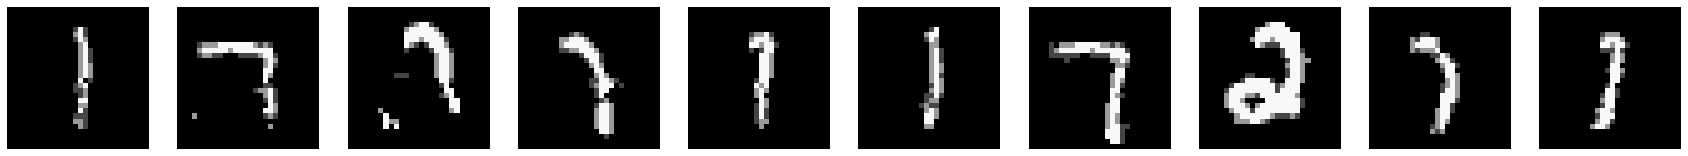

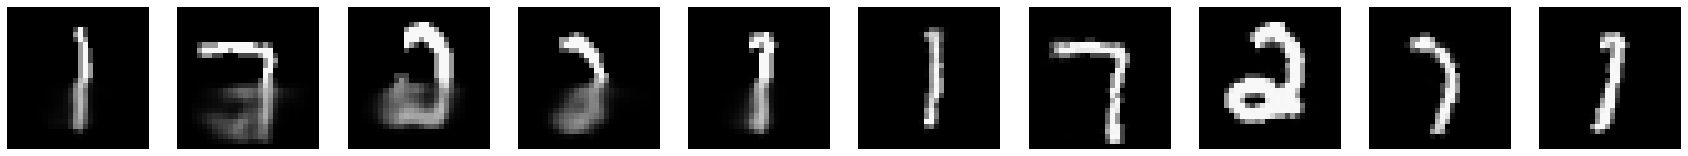

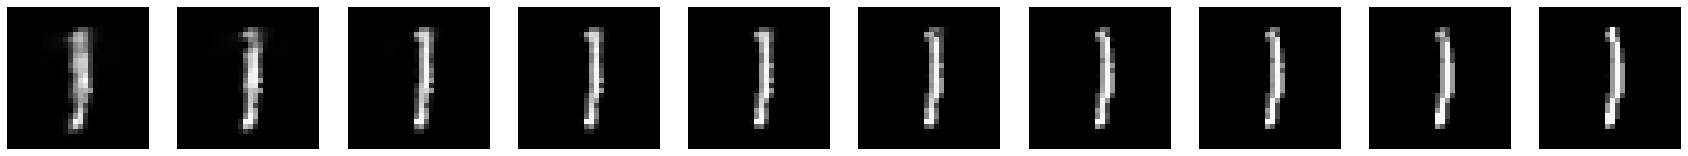

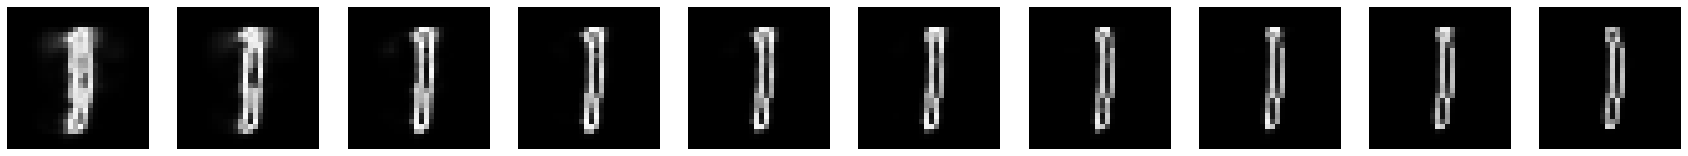

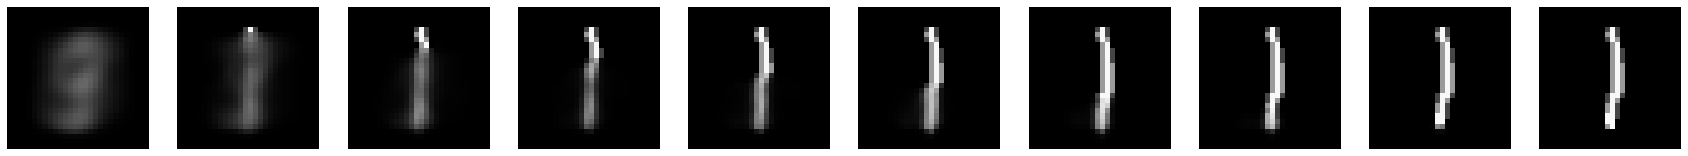

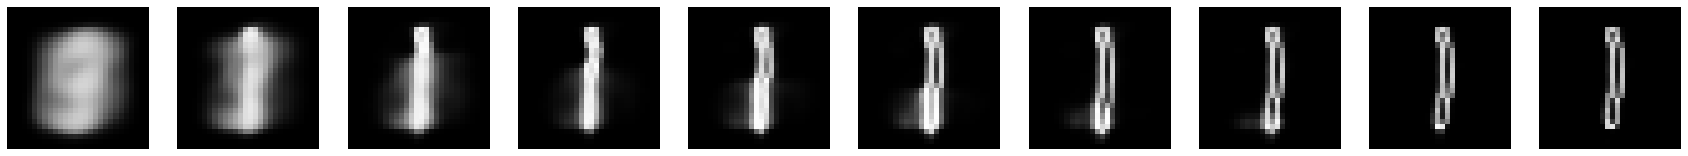

Step 5424, Loss (last minibatch): 0.3228548467159271, Loss (80 step avg.): 0.22209875579969382


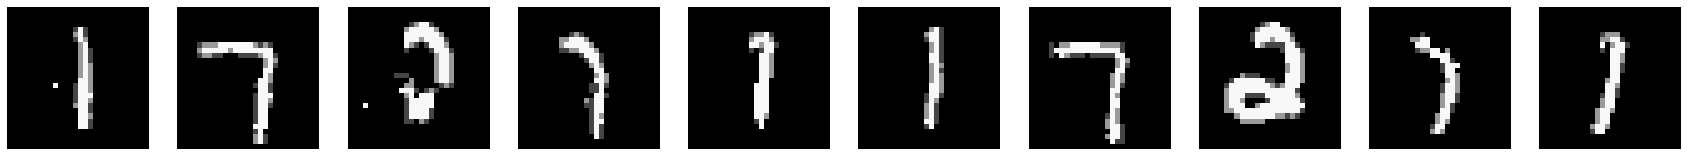

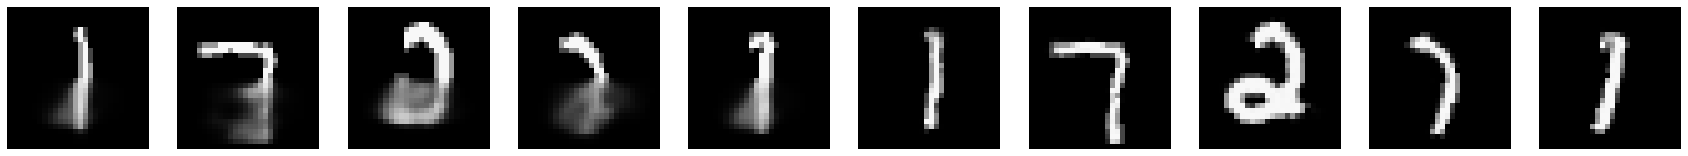

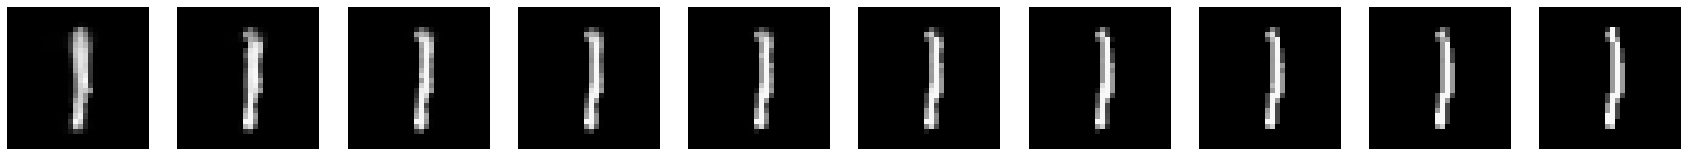

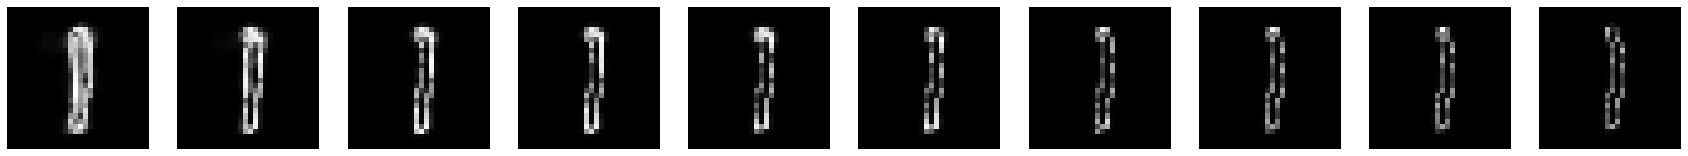

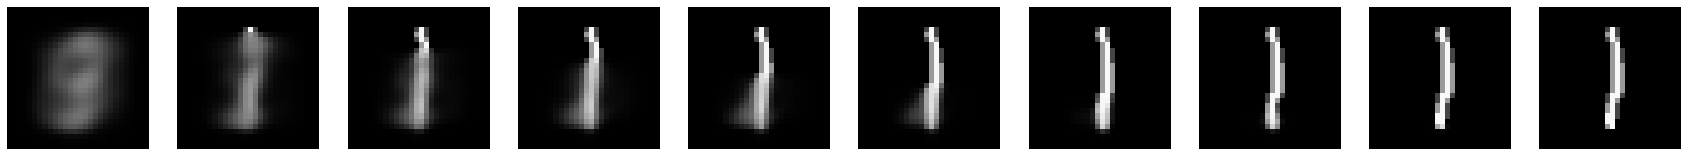

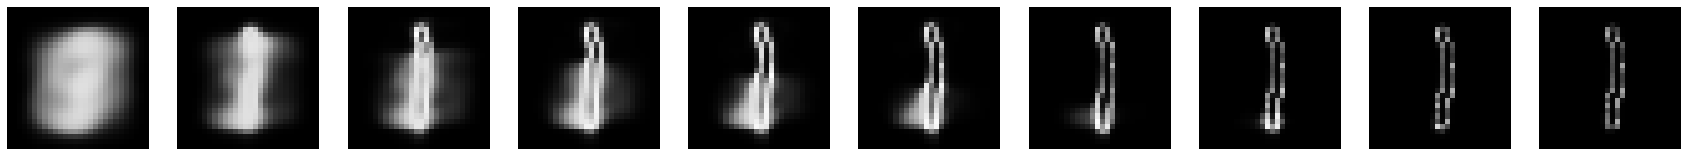

Step 10424, Loss (last minibatch): nan, Loss (80 step avg.): nan


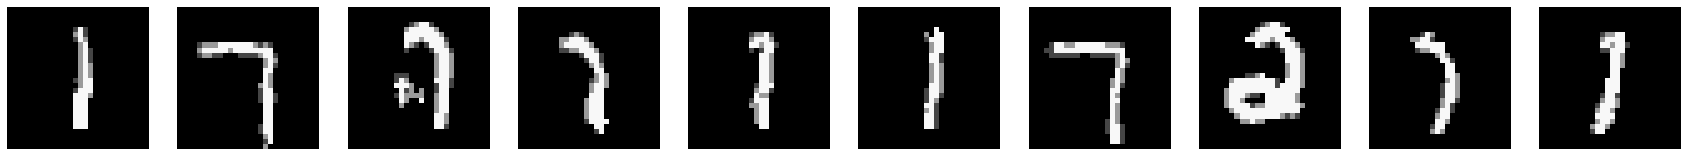

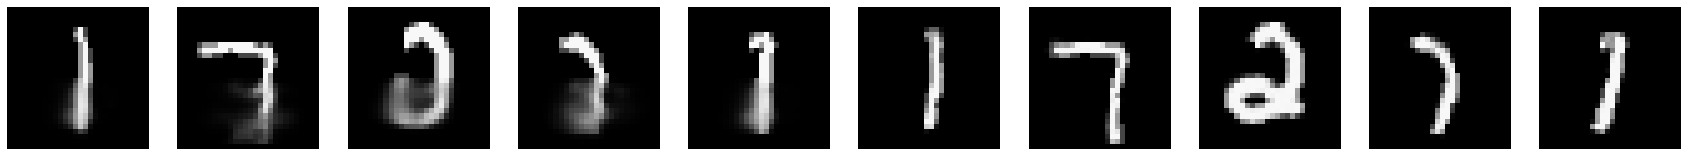

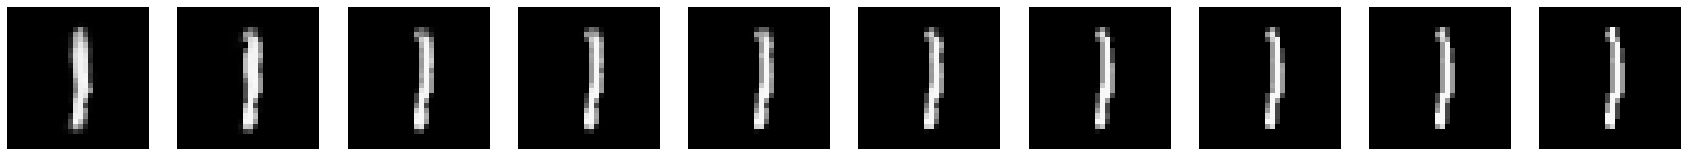

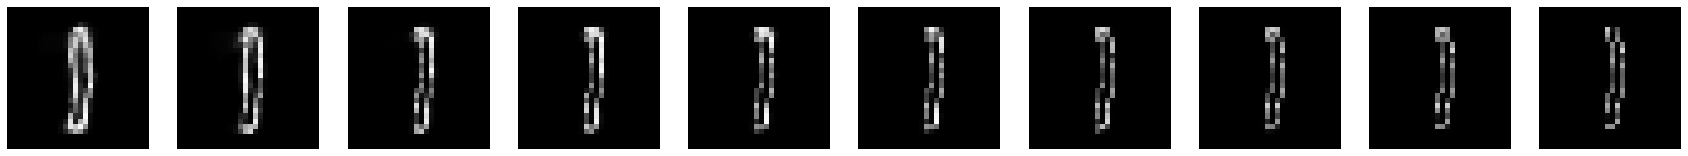

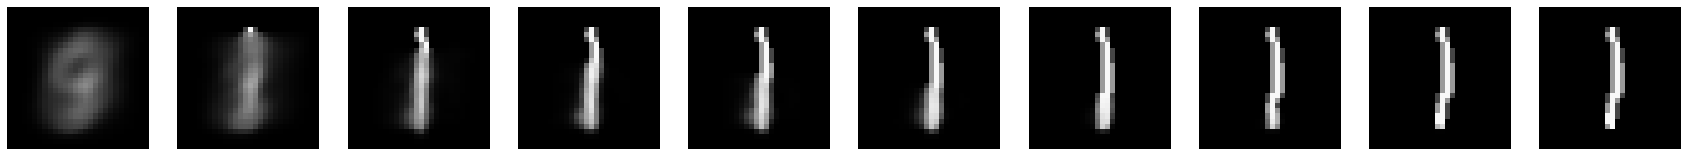

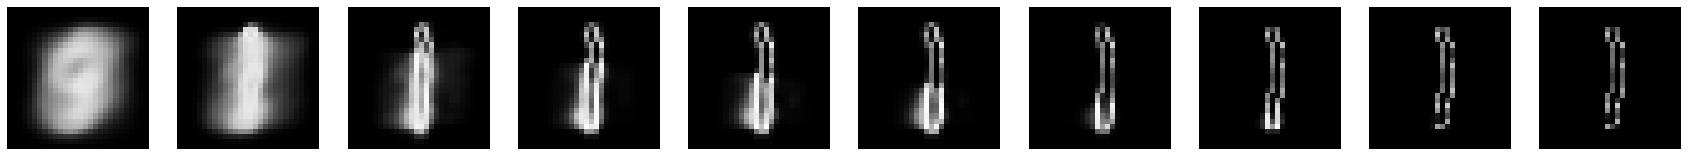

Step 15424, Loss (last minibatch): nan, Loss (80 step avg.): nan


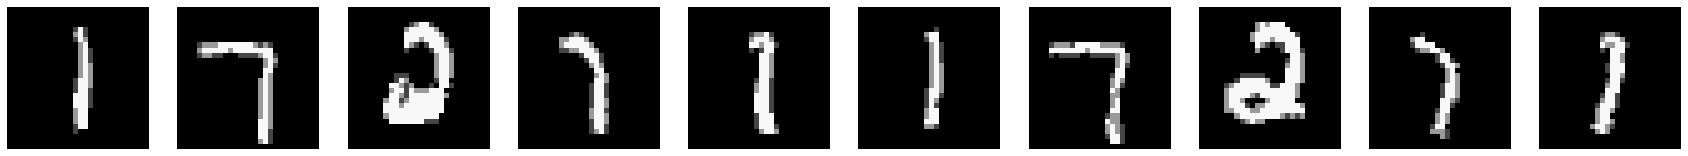

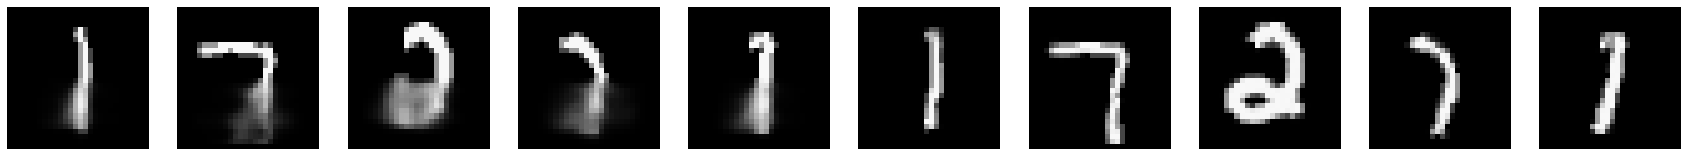

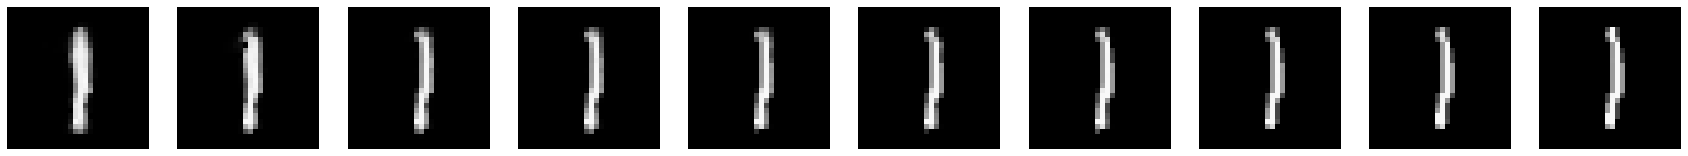

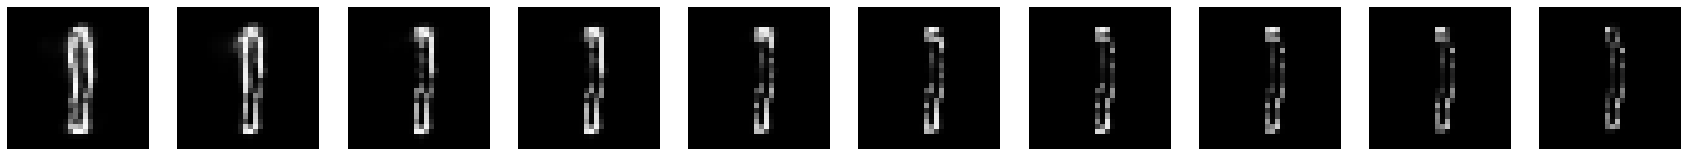

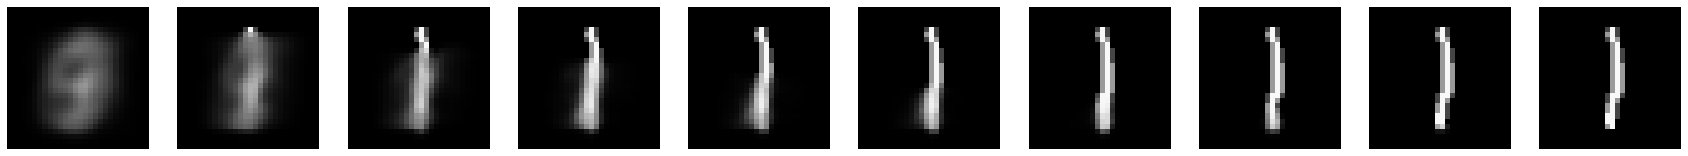

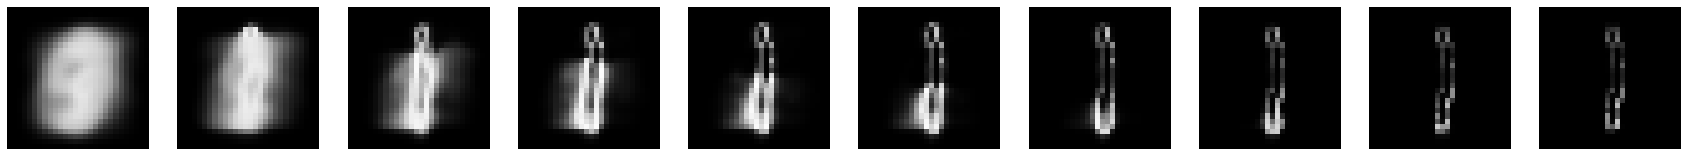

In [ ]:


with strategy.scope():
    training_loop.train()

In [ ]:
model.save(f"models/{model_name}")
config.model.activation_fn = None
json.dump(config, open(f"models/{model_name}/config.json", 'w'), indent=4)

In [ ]:
evaler.process_batch(show_input=True)
evaler.new_test_batch()
evaler.process_batch(show_input=True)